In [206]:
# Check if running on colab
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# pip install any missing packages
if IN_COLAB:
  !pip install equadratures # for standard pip install

import numpy as np                                                                                                                                                                                      
import matplotlib.pyplot as plt
import equadratures as eq

# Uncertainty quantification of CFD simulations

One of the primary uses of `equadratures`, and orthogonal polynomials, is for uncertainty quantification. Given a model under uncertain inputs, we wish to compute the uncertainty in its output. As is demonstrated in this tutorial, we can use polynomial chaos expansion (PCE) to replace the expensive-to-compute computational model with a polynomial, and use this to compute the moments (i.e. mean and variance) of the model's output. 

## Polynomial chaos and Monte Carlo

We start with an important question. Why bother using polynomials for estimating moments? What exactly is the advantage? Moreover, are we guaranteed that we will converge to the Monte Carlo solution? The answer is a resounding yes! Infact this is precisely what Dongbin Xiu and George Karniandakis showed in their seminal paper [1]. As always we begin with some definitions: `Parameter`, `Basis` and `Poly`.

For our model problem, let's consider Rosenbrock's function

$$
f(x_1, x_2) = (1 - x_1)^2 + 100(x_1 - x_2^2)^2,
$$

where we will assume that $x_1$ and $x_2$ are two uncertainties. We will assume that both parameters are Gaussians with $\mu=1$ and $\sigma=2$. Our objective is to compute the mean and variance (the first and second moments) in the output. To set the stage, lets define our computational model

In [140]:
def rosenbrock_fun(x):
    return (1 - x[0])**2 + 100*(x[1] - x[0]**2)**2

Next, we set the number of evaluation points in each direction. Lets opt for 7 points along each direction - more than sufficient to approximate the function exactly.

In [20]:
mu = 1
sigma = 2
variance = sigma**2
x1 = Parameter(distribution="Gaussian", shape_parameter_A=mu, shape_parameter_B=variance)
x2 = Parameter(distribution="Gaussian", shape_parameter_A=mu, shape_parameter_B=variance)
myparams = [x1, x2]

Now, we can set the problem up, compute the coefficients, and then use equadratures to perform a polynomial chaos expansion in order to estimate the mean and the variance of our model output. We wrap this in a function `pce` so that we can try this for a range of polynomial orders later on.

In [134]:
def pce(params,order,function):
    mybasis = eq.Basis('tensor-grid',orders=[order,order])
    mypoly = eq.Poly(myparams, mybasis, method='numerical-integration')
    mypoly.set_model(rosenbrock_fun)
    mean, variance = mypoly.get_mean_and_variance()
    return mean, variance

pce(myparams,4,rosenbrock_fun)

(6803.999999999987, 476659231.99999607)

Now, we compare these results with Monte Carlo. Again, this is wrapped in a function for later.

In [24]:
def monte_carlo(n_samples,function):
    n_samples = int(n_samples)
    s = sigma * np.random.randn(n_samples,2) + mu
    f = np.zeros((n_samples,1))
    for i in range(0, n_samples):
        f[i,0] = function([s[i,0], s[i,1]])
    return np.mean(f), np.var(f)

monte_carlo(1e6,rosenbrock_fun)

(6812.768153873702, 475655678.9051727)

The results are very close! In fact the polynomial approximation results are exact (to machine precision), because Rosenbrock's function is a polynomial itself!

But what order should we use? This is a tough question to answer without any apriori knowledge of the function we wish to obtain statistical moments from. We defer this question to the later tutorials, but for now we will explore the effect of the order on  accuracy. The plots below show the convergence in mean and variance with different number of samples (recall that the polynomial order determines the number of samples/model evaluations required).

In [135]:
# THIS WILL TAKE A WHILE - SKIP IF SHORT ON TIME!
# Test pce
Ntests = 10
n_to_try_pce = np.logspace(0.4,2.0,Ntests,dtype=int)
mean_pce = np.empty(Ntests)
var_pce  = np.empty(Ntests)
for i, n_samples in enumerate(n_to_try_pce):
    #n_samples-1 here as no. of model evals is order+1 in 1D
    mean_pce[i], var_pce[i] = pce(myparams,n_samples-1,rosenbrock_fun) 
    
# Test Monte carlo
Ntests = 10
n_to_try_mc = np.logspace(1,7,10,dtype=int)
mean_mc = np.empty(Ntests)
var_mc  = np.empty(Ntests)
for i, n_samples in enumerate(n_to_try_mc):
    mean_mc[i], var_mc[i] = monte_carlo(n_samples,rosenbrock_fun)

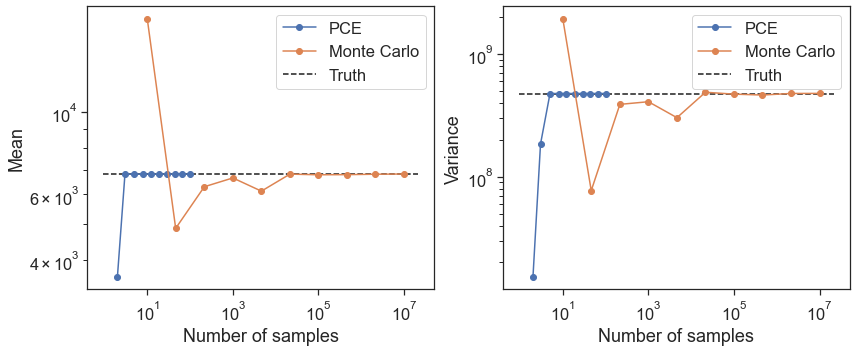

In [138]:
fig1, (ax1, ax2) = plt.subplots(1,2,figsize=(12,5),tight_layout=True)
ax1.set_xlabel('Number of samples'); ax2.set_xlabel('Number of samples')
ax1.set_ylabel('Mean'); ax2.set_ylabel('Variance')
ax1.set_xscale('log'); ax1.set_yscale('log')
ax2.set_xscale('log'); ax2.set_yscale('log')

# Plot PCE
ax1.plot(n_to_try_pce,mean_pce,'-o',label='PCE')
ax1.plot(n_to_try_mc,mean_mc,'-o',label='Monte Carlo')
#Plot MC
ax2.plot(n_to_try_pce,var_pce,'-o',label='PCE')
ax2.plot(n_to_try_mc,var_mc,'-o',label='Monte Carlo')

# Plot True
ax1.hlines(6804.000000000074,ax1.get_xlim()[0],ax1.get_xlim()[1],ls='--',color='k',label='Truth')
ax2.hlines(476659232.00002444,ax2.get_xlim()[0],ax2.get_xlim()[1],ls='--',color='k',label='Truth')

ax1.legend(); ax2.legend()
plt.show()

Clearly, PCE is able to obtain converged estimates of the mean and variance with orders of magnitude fewer samples than vanilla Monte Carlo sampling. In a scenario where each sample is an expensive model evaluation, this could be crucial! 

If the third and fourth order moments (Skewness and Kurtosis) were desired, the above difference is likely to be even more pronounced. But we will leave this for you to try yourself! You can compute these with `Poly.get_skewness_and_kurtosis()`.

## CFD simulations with two aleatory uncertainties

Moving on from the analytical model (the `rosenbrock_fun()` above), we shall now consider a real world model, a computational fluid dynamics (CFD) simulation of the [LS89 turbine blade](https://aboutflow.sems.qmul.ac.uk/events/munich2016/benchmark/testcase2/) with the [SU2](https://su2code.github.io) CFD solver. 

<img src="images/vki_turbine.jpeg" alt="drawing" style="width:400px;"/>

In this simulation the SST model is used to account for the effect of turbulence. This involves solving two additional PDE's for the turbulent kinetic energy $k$ and specific turbulent dissipation $\omega$, which can improve accuracy compared to a 0- or 1-equation turbulence model. However, it adds an additional source of aleatory uncertainty; the specification of inflow boundary conditions for $k$ and $\omega$. 

We wish to estimate the uncertainty in our QoI due to this new uncertainty source. Our Quantity of Interest (QoI) is the loss coefficient for the cascade:

$$
Y_p = \frac{p_{0_{\infty}}-p_{0}}{p_{0_{\infty}}-p_{_{\infty}}}
$$

SU2 uses turbulence intensity $Ti$, and turbulent viscosity ratio $\nu_t/\nu$ as its turbulent boundary conditions ($k = \frac{3}{2}(U \;Ti)$ and $\omega = \frac{k}{\nu}\left(\frac{\nu_t}{\nu} \right)^{-1}$). So our task here is to estimate the uncertainty (variance) in $Y_p$ due to the uncertainty in $k$ and $\omega$.

As with the analytic example, the workflow involves first defining `Parameter`'s, a `Basis`, and a `Polynomial`. We can often estimate $Ti$ with some confidence, since it can be measured using a hot-wire probe. However, $\nu_t/\nu$ is physically more vague, and it is more of an unknown quantity. For this reason we set $Ti$ to have a gaussian distribution, while for $\nu_t/\nu$ we can only say it lies within a certain range, therefore we choose a uniform distribution. 

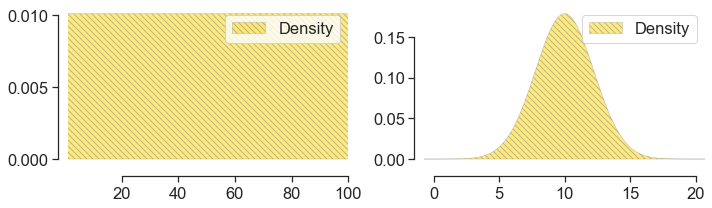

In [207]:
s1 = Parameter(distribution='uniform', lower=1.0, upper=100, order=3) #turb2lamviscosity
s2 = Parameter(distribution='Gaussian', shape_parameter_A=10, shape_parameter_B=5, order=3) #Ti
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,3),tight_layout=True)
s1.plot_pdf(ax=ax1,show=False); s2.plot_pdf(ax=ax2,show=False)
plt.show()

Next we define a Basis and Poly, like before. This time the problem is bivariate, lets keep it simple and choose a `tensor-grid` basis.

In [164]:
mybasis = Basis('tensor-grid')
mypoly = Poly(parameters=[s1,s2], basis=mybasis, method='numerical-integration')

This time running set_model is a little more involved, since our model is a CFD simulation instead of a simple polynomial function. We first ask `equadratures` for the quadrature points, and save them to disk.

Viscosity ratio 	 Ti
[[ 7.87375258  4.78009112]
 [ 7.87375258  8.34091854]
 [ 7.87375258 11.65908146]
 [ 7.87375258 15.21990888]
 [33.67093834  4.78009112]
 [33.67093834  8.34091854]
 [33.67093834 11.65908146]
 [33.67093834 15.21990888]
 [67.32906166  4.78009112]
 [67.32906166  8.34091854]
 [67.32906166 11.65908146]
 [67.32906166 15.21990888]
 [93.12624742  4.78009112]
 [93.12624742  8.34091854]
 [93.12624742 11.65908146]
 [93.12624742 15.21990888]]


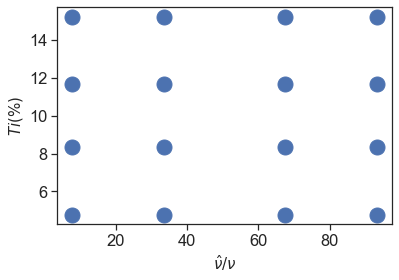

In [165]:
# Get the DOE points
pts = mypoly.get_points()

# Print and save to file
print('Viscosity ratio \t Ti')
print(pts)
np.save('points_to_run.npy', pts)

# Plot the DOE points
plt.plot(pts[:,0], pts[:,1], 'bo', markersize=15)
plt.xlabel(r'$\hat{\nu}/\nu$', fontsize=15)
plt.ylabel(r'$Ti (\%)$', fontsize=15)
plt.show()

The above plot shows our Design of Experiment (DoE). It is relatively straightforward to take the `points_to_run.npy` file and go away and run a set of CFD simulations at these DoE points (especially with the python wrapper functionality of the [SU2](https://su2code.github.io/) CFD code!). The `lossarray_sst.npy` file located in the same directory as this notebook contains the loss coefficient $Y_p$ results obtained by doing exactly this with SU2. 

Lets load up the loss coefficient $Y_p$ values for our DoE, and pass this data to `mypoly` with `set_model`. 

In [204]:
# Load the Yp array from file
if IN_COLAB: 
    !wget https://github.com/equadratures/equadratures.github.io/blob/master/_documentation/tutorials/lossarray_sst.npy -O data/lossarray_sst.npy
Yp = np.load('data/lossarray_sst.npy').reshape(-1, 1)

# Print the Yp array
print('SA ratio \t Ti \t\t Y_p')
print(np.hstack([pts,Yp]))

mypoly.set_model(Yp)

SA ratio 	 Ti 		 Y_p
[[7.87375258e+00 4.78009112e+00 5.30310580e-02]
 [7.87375258e+00 8.34091854e+00 5.28644236e-02]
 [7.87375258e+00 1.16590815e+01 5.26925252e-02]
 [7.87375258e+00 1.52199089e+01 5.24967211e-02]
 [3.36709383e+01 4.78009112e+00 5.32419115e-02]
 [3.36709383e+01 8.34091854e+00 5.32333854e-02]
 [3.36709383e+01 1.16590815e+01 5.30672169e-02]
 [3.36709383e+01 1.52199089e+01 5.28340593e-02]
 [6.73290617e+01 4.78009112e+00 5.32581624e-02]
 [6.73290617e+01 8.34091854e+00 5.33894321e-02]
 [6.73290617e+01 1.16590815e+01 5.32981622e-02]
 [6.73290617e+01 1.52199089e+01 5.30067064e-02]
 [9.31262474e+01 4.78009112e+00 5.32606790e-02]
 [9.31262474e+01 8.34091854e+00 5.34980151e-02]
 [9.31262474e+01 1.16590815e+01 5.34417742e-02]
 [9.31262474e+01 1.52199089e+01 5.32224419e-02]]


Now all that remains is to compute the mean and variance of $Y_p$.

In [205]:
mean, var = mypoly.get_mean_and_variance()
print('Mean Yp = %.2g' %(mean))
print('95%% confidence interval for Yp = %.2g (%.2g%%)' %(1.96*np.sqrt(var),100*1.96*np.sqrt(var)/mean))

Mean Yp = 0.053
95% confidence interval for Yp = 0.00047 (0.88%)


So our 95% confidence interval due to uncertainty in inflow turbulence specficiation is $Y_p\pm 0.00047$. This seems small but is actually 0.88% of the mean $Y_p$ value, so may be significant depending on your use case. 

### Checking the accuracy of the polynomial approximation

A word of warning here. Accurate computed moments rely on the polynomial approximation being accurate. We have ommited checks of the polynomial accuracy so far for brevity, but usually this would be done before we call `get_mean_and_variance`. These checks would usually involve checking the $R^2$ score and/or Root Mean Squared Error (RMSE) at the quadrature points.

In [174]:
y_pred = mypoly.get_polyfit(pts).squeeze()
y_true = Yp.squeeze()
r2 = eq.datasets.score(y_pred,y_true,metric='r2')
rmse = eq.datasets.score(y_pred,y_true,metric='rmse')
print('R2 = %.3g, RMSE = %.3g' %(r2,rmse))

R2 = 1, RMSE = 1.76e-16


So we are happy with the accuracy in this case!

### Dealing with invalid simulation results

Any CFD practitioner is probably all too familiar with CFD simulations not converging! So what happens to the above procedure in this case? To investigate, we set a number of our DoE samples to NaN.

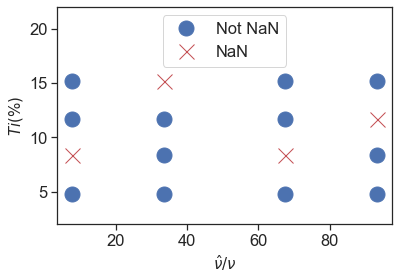

In [176]:
# Enter list of points you want to set to NaN here (0 to 15)
indices = [1,7,9,14]
indices_to_set_to_NaN = np.asarray(indices)

# Set chosen points to NaN
Yp_with_NaNs = deepcopy(Yp)
Yp_with_NaNs[indices_to_set_to_NaN] = np.nan * indices_to_set_to_NaN.reshape(len(indices_to_set_to_NaN),1)

# Plot the DOE points
NaN = np.isnan(Yp_with_NaNs).flatten()
plt.plot(pts[~NaN,0], pts[~NaN,1], 'bo', markersize=15,label='Not NaN')
plt.plot(pts[NaN,0], pts[NaN,1], 'rx', markersize=15,label='NaN')
plt.xlabel(r'$\hat{\nu}/\nu$', fontsize=15)
plt.ylabel(r'$Ti (\%)$', fontsize=15)
plt.legend(loc='upper center')
plt.ylim([2,22])
plt.show()

Now pass the ``Yp_with_NaNs`` array to ``mypoly`` with ``set_model()``.

In [177]:
mypoly_NaN = deepcopy(mypoly)
mypoly_NaN.set_model(Yp_with_NaNs)

The code will now use a least-squares technique that will ignore input-output pairs of your model that have NaNs. This will likely compromise computed statistics.


So the code has automatically detected that some of the model evaluations are NaN, and it has switched to `least-squares` regression which can cope with missing samples. Lets compute the moments and see how accurate they are compared to the case without NaNs.

In [178]:
# Compute moments
mean_with_NaNs, var_with_NaNs = mypoly_NaN.get_mean_and_variance()

# Print
print('Original  Mean = %.3g, Original  confidence interval = %.3g%%' %(mean,100*1.96*np.sqrt(var)/mean))
print('With NaNs Mean = %.3g, with NaNs confidence interval = %.3g%%' %(mean_with_NaNs,100*1.96*np.sqrt(var_with_NaNs)/mean_with_NaNs))
err_mean = 100.*(mean_with_NaNs-mean)/mean
err_var  = 100.*(var_with_NaNs -var) /var
print('Errors as a %% of original values: mean = %.3f%%, variance = %.3f%%' %(err_mean,err_var))

Original  Mean = 0.0532, Original  confidence interval = 0.881%
With NaNs Mean = 0.0532, with NaNs confidence interval = 0.873%
Errors as a % of original values: mean = 0.019%, variance = -1.755%


Not too bad! This is usually the case, as long as we don't have too many invalid samples...

### Sensitivity analysis

As covered by a previous [blog post](https://discourse.effective-quadratures.org/t/sensitivity-analysis-with-effective-quadratures/30), `get_sobol_indices` computes the Sobol indices, which quantify the sensitivity of the model output to the input parameters. 

We now do this for the first order sobol indices $S_i$.

In [179]:
mypoly.get_sobol_indices(order=1)

{(0,): 0.8402230587095255, (1,): 0.13229796898564183}

Clearly, $Y_p$ is significantly more sensitive to $s_1$ ($\nu_t/\nu$) than $s_2$ ($Ti$). This is potentially a problem when we are looking to run CFD simulations of this nature, since ($\nu_t/\nu$) is more difficult to measure, so we often don't have a good idea of what its value should be. 

### Visualising the response surface

We can obtain a a surrogate model $\hat{f}(s_1,s_2)$ from ``mypoly`` with ``get_polyfit``. Lets plot this to visualise the model's response to our parameters $s_1$ and $s_2$. 

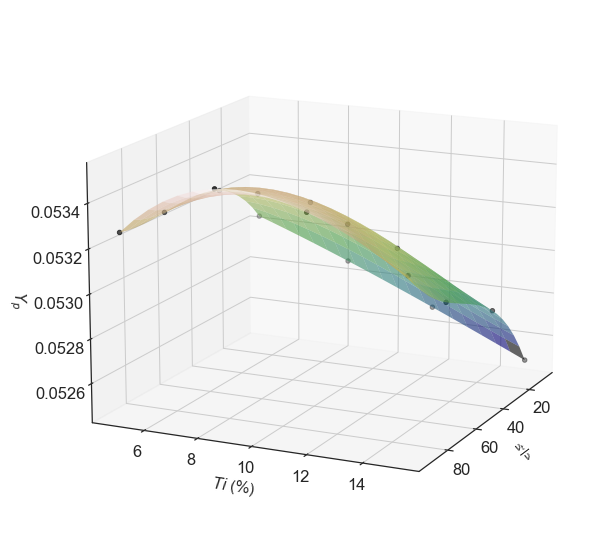

In [201]:
# Get the mypolyfit model
mypolyfit = mypoly.get_polyfit

# Get the sampling points
pts = mypoly.get_points()

# Sample the polyfit at N number of points so we can plot it
N = 20
s1_samples = np.linspace(pts[0,0], pts[-1,0], N)
s2_samples = np.linspace(pts[0,1], pts[-1,1], N)
[S1, S2] = np.meshgrid(s1_samples, s2_samples)
S1_vec = np.reshape(S1, (N*N, 1))
S2_vec = np.reshape(S2, (N*N, 1))
samples = np.hstack([S1_vec, S2_vec])
PolyDiscreet = mypolyfit( samples )
PolyDiscreet = np.reshape(PolyDiscreet, (N, N))

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

# Plot the discretised poly PolyDiscreet as a surface
surf = ax.plot_surface(S1, S2, PolyDiscreet, rstride=1, cstride=1, cmap=plt.cm.gist_earth, linewidth=0, alpha=0.6, label='Tensor grid')
# Plot the actual doe points as black circles
scatter = ax.scatter(pts[:,0],pts[:,1],Yp, c='k', marker='o')

ax.set_xlabel(r'$\frac{\nu_t}{\nu}$', fontsize=15,labelpad=10)
ax.set_ylabel(r'$Ti$ ($\%$)', fontsize=15, labelpad=10)
ax.set_zlabel(r'$Y_p$', fontsize=15, labelpad=20); ax.tick_params(axis='z', which='major', pad=10)
ax.view_init(15, 25)
plt.show()

## References
[1] Xiu, D., and Karniadakis, G. E., The Wiener-Askey polynomial chaos for stochastic differential equations. SIAM J. Sci. Comput. 24.2: 619-644. [Paper](https://doi.org/10.1137/S1064827501387826).